In [31]:
from numpy import mean, std
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [32]:
# define date range
start_date = '2005-01-22'
end_date  = datetime.today().strftime('%Y-%m-%d')


In [125]:
# retrieve markets

data = yf.download(['GC=F', 'QLTA', '^TNX', 'SPY'], start_date, end_date)
#data = yf.download(['MSFT', 'TSLA', 'AAPL', 'AMZN', 'SPY'], start_date, end_date)

print(data.head())

[*********************100%***********************]  4 of 4 completed
           Adj Close                        Close                        High  \
                GC=F QLTA        SPY   ^TNX  GC=F QLTA        SPY   ^TNX GC=F   
Date                                                                            
2000-01-24       NaN  NaN  91.621071  6.684   NaN  NaN  140.34375  6.684  NaN   
2000-01-25       NaN  NaN  92.661522  6.684   NaN  NaN  141.93750  6.684  NaN   
2000-01-26       NaN  NaN  91.927101  6.680   NaN  NaN  140.81250  6.680  NaN   
2000-01-27       NaN  NaN  91.559853  6.685   NaN  NaN  140.25000  6.685  NaN   
2000-01-28       NaN  NaN  88.703735  6.648   NaN  NaN  135.87500  6.648  NaN   

                 ...        Low        Open                         Volume  \
           QLTA  ...        SPY   ^TNX GC=F QLTA         SPY   ^TNX   GC=F   
Date             ...                                                         
2000-01-24  NaN  ...  139.40625  6.684  NaN  NaN

In [126]:
# visualization functions

def rrg_plot(df, symbol, period = 20):
    """
    Method to visualize RRG plot for one market/symbol. The benchmark is SPY
    """
    df = df.copy()
    df =df.iloc[-period:]
    
    last = df.iloc[-1]    
    others = df.iloc[:-1]    

    plt.axvline(x = 0, color = 'b')
    plt.axhline(y = 0, color = 'b')

    plt.plot(df[f'{symbol}_ratio'], df[f'{symbol}_momentum'])
    plt.scatter(last[f'{symbol}_ratio'], last[f'{symbol}_momentum'], marker='o')
    plt.scatter(others[f'{symbol}_ratio'], others[f'{symbol}_momentum'], marker='x')

    plt.title(symbol)
    plt.xlabel("RS ratio")
    plt.ylabel("RS momentum")

    plt.show()
    
def visualize_rs(symbol:str, window_len=120):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(ratio_df[f'{symbol}_ratio'][-window_len:], label=ratio_df.columns)
    ax[0].set_title(f'RS ratio {symbol}')
    #ax[0].legend()

    ax[1].plot(momentum_df[f'{symbol}_momentum'][-window_len:], label=momentum_df.columns)
    ax[1].set_title(f'RS momentum {symbol}')
    #ax[1].legend()
    plt.show()

### RRG on price complex

In [ ]:

def rs_ratio(prices_df, benchmark, window=10):
    
    """
    Function that returns dataframe with relative strength ratio for each symbol (days)
    """
    
    # create new dataframe
    index = prices_df.index
    ratio_df = pd.DataFrame(index=index)
    ratio_df.index = pd.to_datetime(ratio_df.index)

    benchmark = benchmark.rolling(4).mean()

    for column in prices_df:
        prices_df[column] = prices_df[column].rolling(4).mean()

        rs = (prices_df[column] / benchmark) * 100
        rs = rs.rolling(window).mean()
        rs_ratio = [np.nan for i in range(int(window * 2))]
        
        for i in range(int(window * 2), len(rs)):
            rs_subset = rs[: i+1]                 
            ratio = (rs_subset[i] - rs_subset[int(-window * 2) : i-1].mean()) / rs_subset[int(-window * 2) : i-1].std() +1
            rs_ratio.append(ratio)    

        rs_ratio = pd.Series(rs_ratio, index = index)
        
        rs_ratio = rs_ratio.rolling(8).mean()

        ratio_df[f'{column}_ratio'] = rs_ratio
    
    ratio_df.dropna(axis=0, how='all', inplace=True)
    return ratio_df

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])


def rs_momentum(ratio_df):
    index = ratio_df.index

    momentum_df = pd.DataFrame(index=index)

    for column in ratio_df:
        name = column.split('_')[0]
        rs_momentum = ratio_df[column] - ratio_df[column].shift(5)

        momentum_df[f'{name}_momentum'] = rs_momentum

    return momentum_df

momentum_df = rs_momentum(ratio_df)

In [ ]:
# visualize relative strength ratio and momentum

#visualize_rs('MSFT', 140)
#visualize_rs('TSLA', 140)


visualize_rs('QLTA', 140)
visualize_rs('GC=F', 140)
visualize_rs('^TNX', 140)

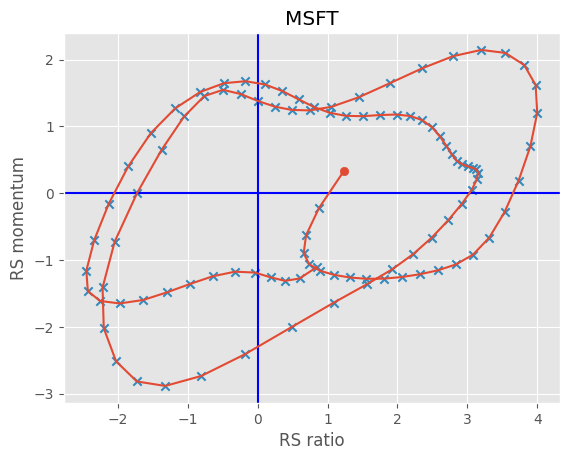

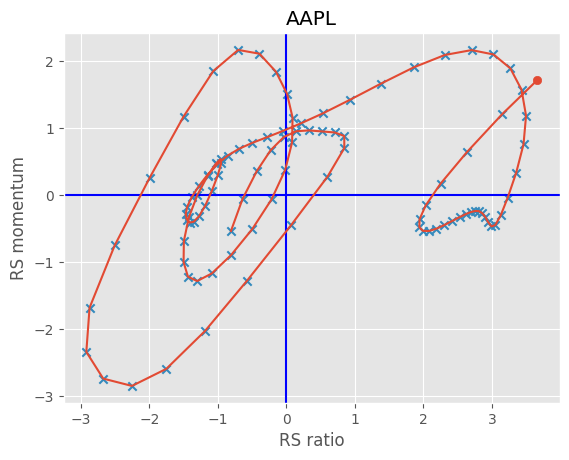

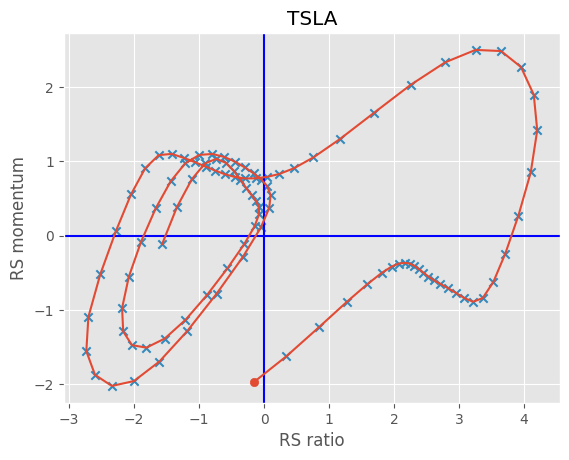

In [65]:

    
df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

rrg_plot(df, 'QLTA', 40)
rrg_plot(df, 'GC=F', 40)
rrg_plot(df, '^TNX', 40)

#rrg_plot(df, 'MSFT', 100)
#rrg_plot(df, 'AAPL', 100)
#rrg_plot(df, 'TSLA', 100)

### RRG on return simple (best for stocks)

In [121]:
def rs_ratio(prices_df, benchmark, window=10):
    
    """
    Function that returns dataframe with relative strength ratio for each symbol (days)
    """
    
    # create new dataframe
    index = prices_df.index
    ratio_df = pd.DataFrame(index=index)
    ratio_df.index = pd.to_datetime(ratio_df.index)
    
    benchmark = benchmark.rolling(12).mean()
    benchmark = benchmark.pct_change(5)
    
    #plt.plot(benchmark[-200:])

    for column in prices_df:
        prices_df[column] = prices_df[column].rolling(12).mean()
        prices_df[f'{column}_return'] = prices_df[column].pct_change(5)
        prices_df[f'{column}_ratio'] = prices_df[f'{column}_return'] - benchmark
        
    return prices_df.rolling(10).mean()

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])

In [122]:
def rs_momentum(ratio_df):
    index = ratio_df.index

    momentum_df = pd.DataFrame(index=index)

    for column in ratio_df:
        name = column.split('_')[0]
        rs_momentum = ratio_df[column] - ratio_df[column].shift(5)
        momentum_df[f'{name}_momentum'] = rs_momentum.rolling(4).mean()
        
    return momentum_df

momentum_df = rs_momentum(ratio_df)

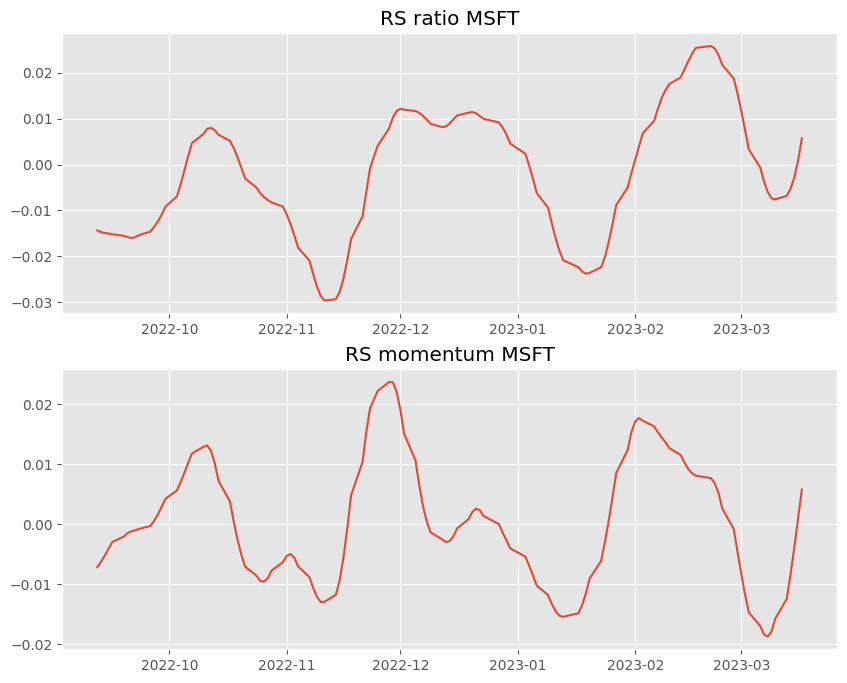

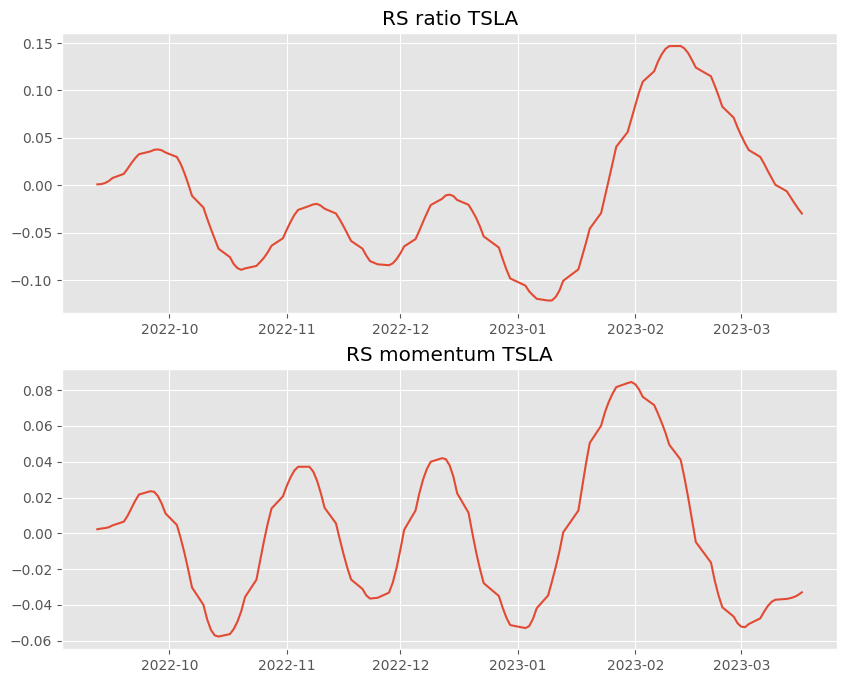

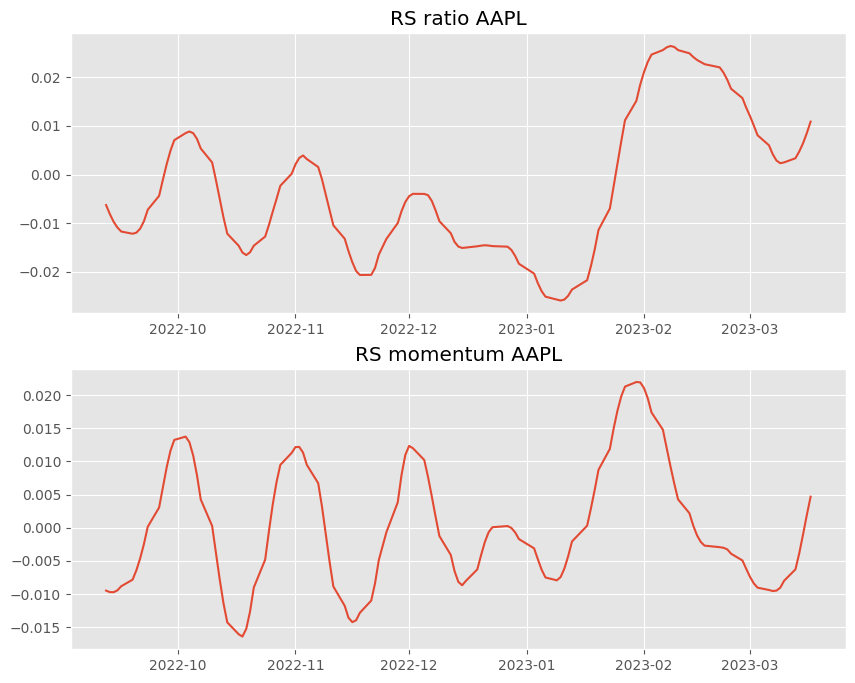

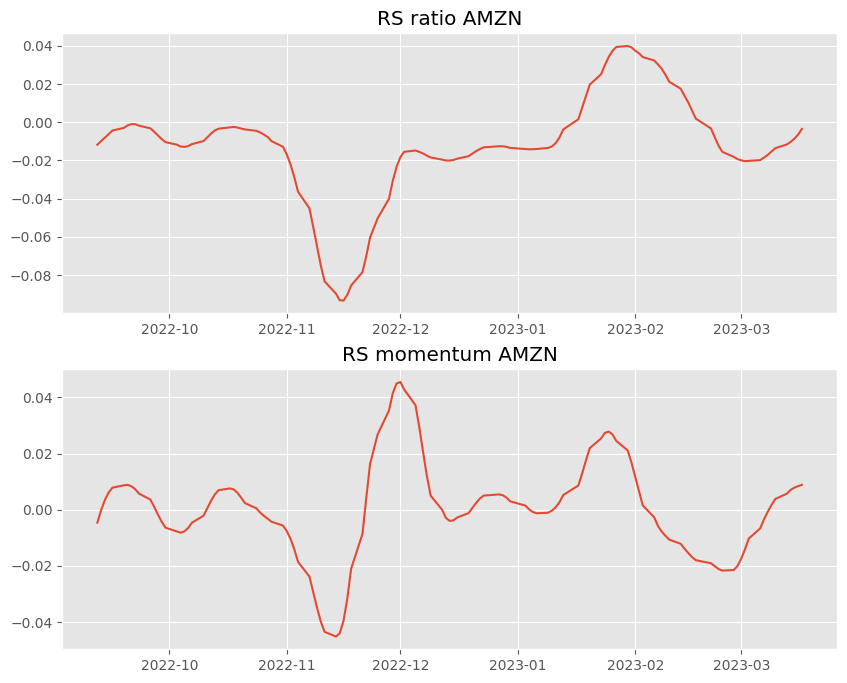

In [123]:
visualize_rs('MSFT', 130)
visualize_rs('TSLA', 130)
visualize_rs('AAPL', 130)
visualize_rs('AMZN', 130)

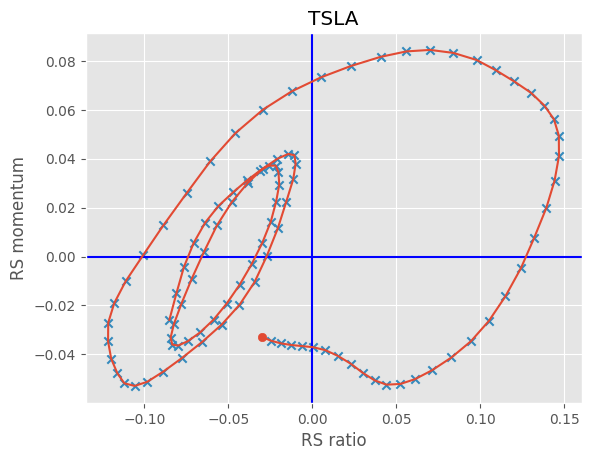

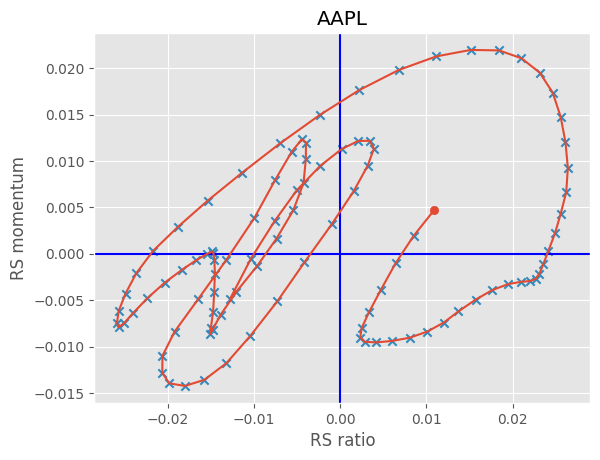

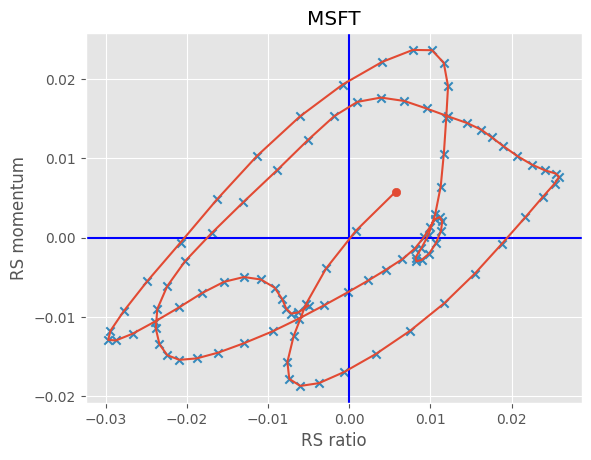

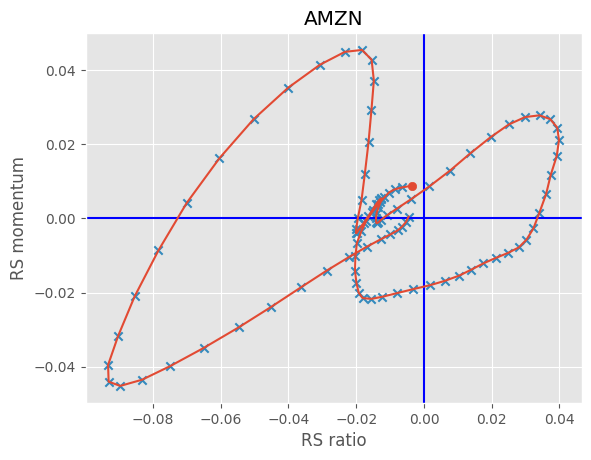

In [124]:

    
df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

#rrg_plot(df, 'QLTA', 100)
#rrg_plot(df, 'GC=F', 100)
#rrg_plot(df, '^TNX', 100)

rrg_plot(df, 'TSLA', 100)
rrg_plot(df, 'AAPL', 100)
rrg_plot(df, 'MSFT', 100)
rrg_plot(df, 'AMZN', 100)

### RRG on price, last window only

### RRG on returns, complex

In [104]:
# ratio window only

def rs_ratio(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength ratio for each symbol
    """
    
    ratio_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    benchmark = benchmark.rolling(7).mean()

    index = prices_df.index
    for column in prices_df:
        prices_df[column] = prices_df[column].rolling(7).mean()

        rs_serie= []
        
        for i in range(window*2, len(prices_df[column])):
            
            subset_asset = prices_df[column][:i+1]
            subset_asset = subset_asset[-window*2:]
            
            subset_benchmark = benchmark[:i+1]
            subset_benchmark = subset_benchmark[-window*2:]
            
            rs = subset_asset / subset_benchmark * 100 
            rs = (rs - rs.mean()) / rs.std()

            rs_serie.append(rs[-1])
            
        rs_serie = pd.Series(rs_serie, index = index[window*2:])
        rs_ratio = rs_serie.rolling(10).mean()
       # rs_ratio = (rs_ratio - rs_ratio.mean()) / rs_ratio.std()
        
        ratio_df[f'{column}_ratio'] = rs_ratio
        
    ratio_df.dropna(axis=0, how='all', inplace=True)
    
    return ratio_df

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])

In [105]:

def rs_momentum(ratio_df):
    index = ratio_df.index

    momentum_df = pd.DataFrame(index=index)

    for column in ratio_df:
        name = column.split('_')[0]
        rs_momentum =  ratio_df[column] - ratio_df[column].shift(5)
        momentum_df[f'{name}_momentum'] = rs_momentum.rolling(4).mean()
        
    return momentum_df

momentum_df = rs_momentum(ratio_df)

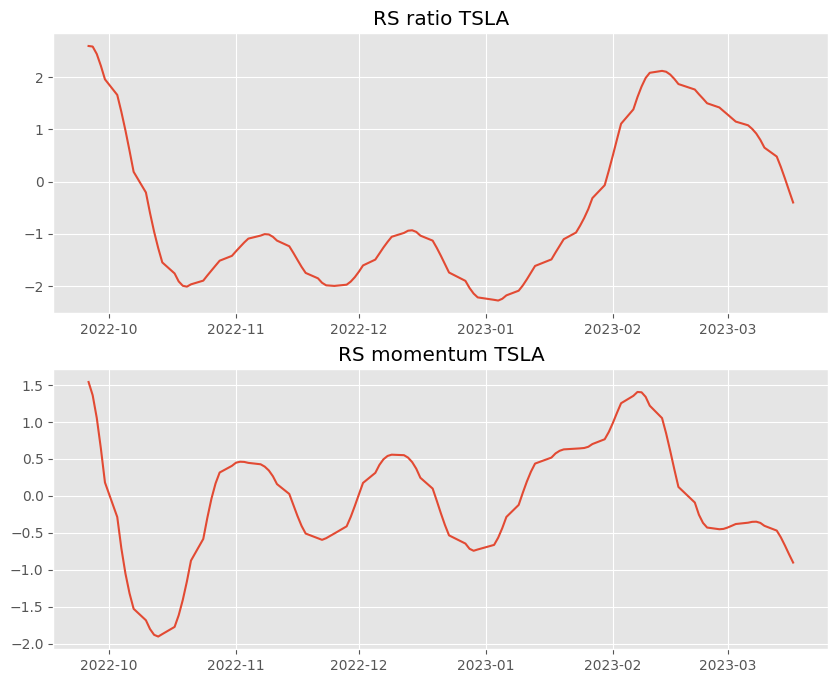

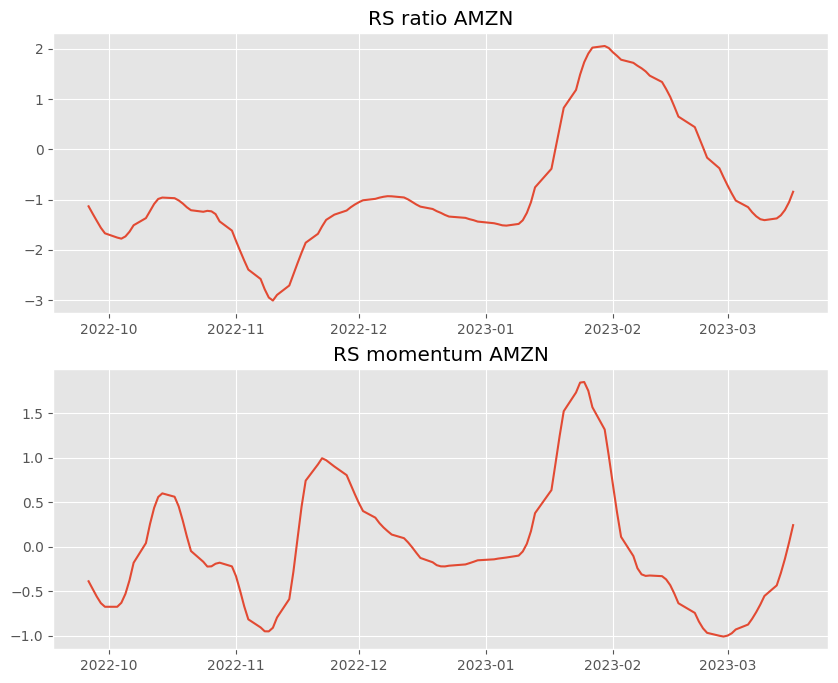

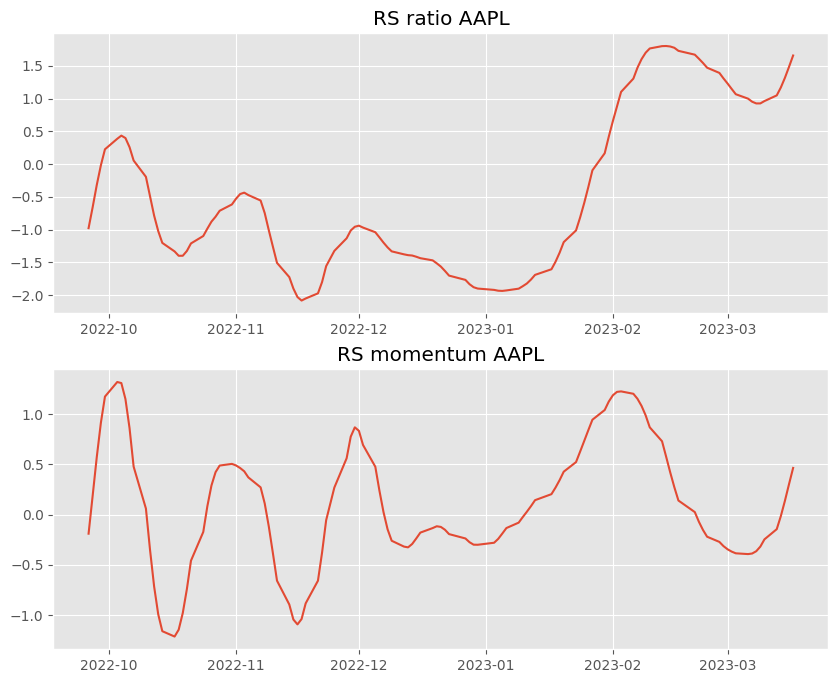

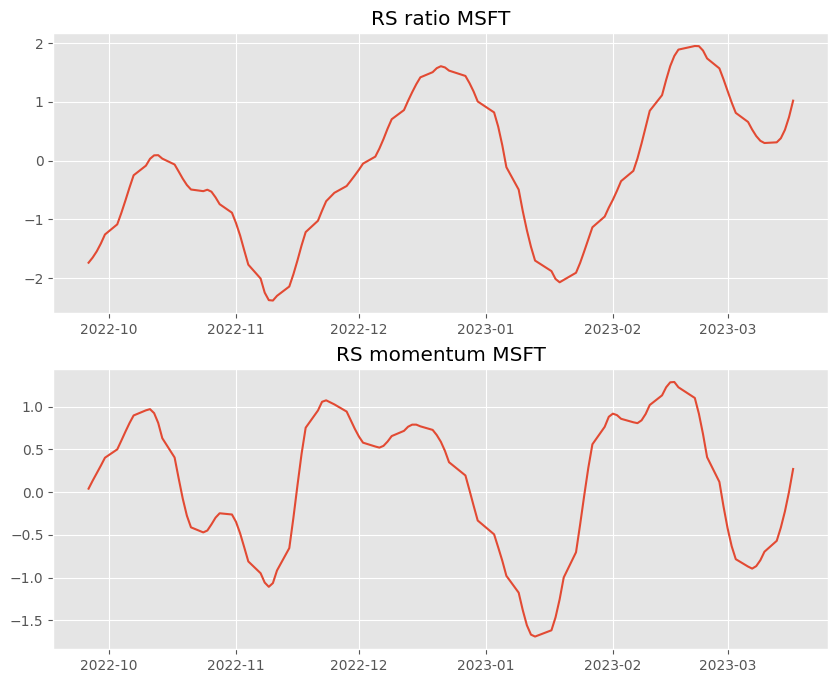

In [106]:
# visualize relative strength and ratio
    
#visualize_rs('^TNX')
visualize_rs('TSLA')
visualize_rs('AMZN')
visualize_rs('AAPL')
visualize_rs('MSFT')

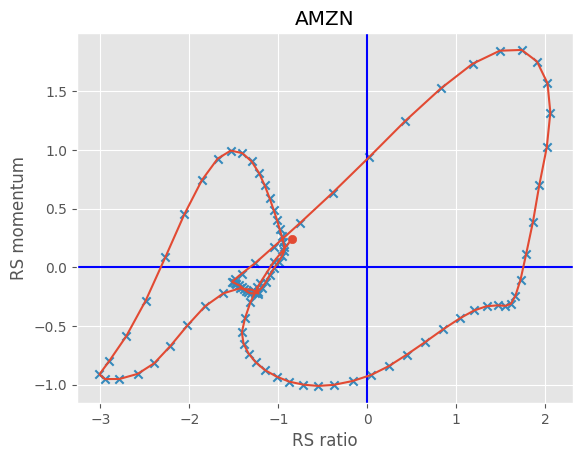

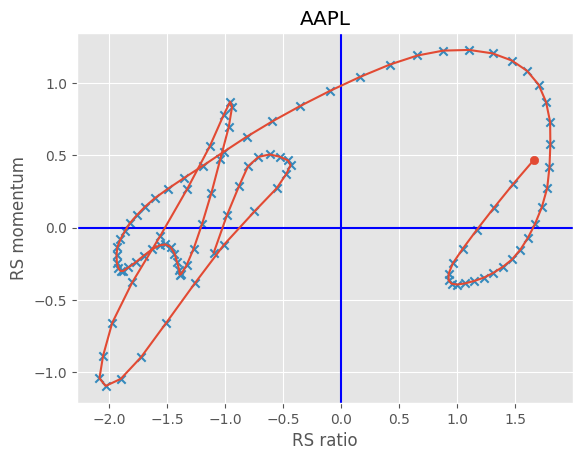

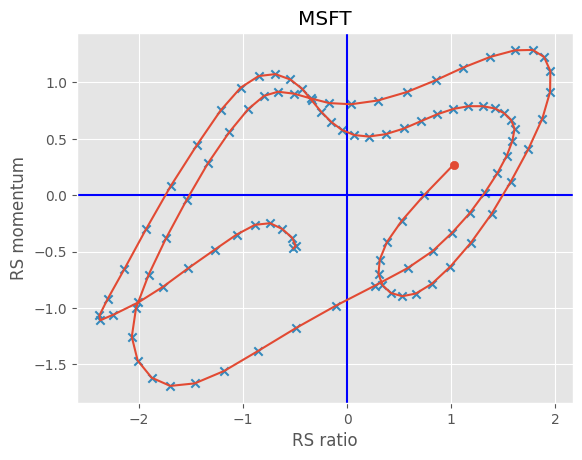

In [107]:
### rrg plot

df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

#rrg_plot(df, 'QLTA', 200)
#rrg_plot(df, 'GC=F', 200)
#rrg_plot(df, '^TNX', 200)

rrg_plot(df, 'AMZN', 100)
rrg_plot(df, 'AAPL', 100)

rrg_plot(df, 'MSFT', 100)